# Apprendimento Supervisionato


## Sommario
La rappresentazione tramite modello NDOM discussa nella sezione precedente ci ha permesso, di fatto, di ingegnerizzare e aggiungere al DS iniziale 8 nuove feature, `task1`, `task2`, ..., `task8`.

In questa sezione costruiamo e valutiamo dei modelli di apprendimento supervisionato (SL) che possano predire il valore della feature target `metric`.

Innanzitutto, una prima osservazione da fare è che in tutti i modelli di SL il dataset NON comprende le feature `page_ungrouped_multim`, `page_template` e `page_menu_or`. Ricordiamo che queste sono dei fattori di decisione che l'utente considera osservando direttamente la pagina e che si rintengono non osservabili a partire dal solo codice sorgente.

Una seconda precisazione da fare riguarda il fatto che assumeremo, salvo diversamente specificato, che ciascun iperparametro del NDOM del sito abbia il valore di default (descritto precedente sezione *Decisioni di Progetto*).


## Operazioni iniziali

### Caricamento DS ed esplicitazione features


In [2]:
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/icon-745751/SCUANAGRAFE202324_3_gt_final.csv")

ds3_features_pk = ["school_id", "page_url"]
ds3_features_part1 = ["page_template", "page_menu_or", "page_ungrouped_multim"]
ds3_features_part2 = [
    "page_load_time_ms",
    "page_width",
    "page_height",
    "NDOM_nodes",
    "NDOM_height",
]
ds3_features_part3 = ["task1", "task2", "task3", "task4", "task5", "task6", "task7", "task8"]
ds3_target = "metric"

# features
ds3_features = (
    ds3_features_pk + ds3_features_part1 + ds3_features_part2 + ds3_features_part3
)
ds3_features.append(ds3_target)

# >>>
df.head(3)

,school_id,page_url,page_load_time_ms,page_width,page_height,NDOM_nodes,NDOM_height,page_template,page_menu_or,page_ungrouped_multim,metric,task1,task2,task3,task4,task5,task6,task7,task8
0,CBSL00201A,https://www.liceopagano.edu.it,516,1604,848,1,0,9.0,2.0,6.0,2.9,6.50,6.50,6.50,6.5,6.50,6.5,6.50,6.50
1,RGTD03002X,https://www.itcbesta.edu.it,1278,1587,2441,162,7,6.0,1.0,8.0,3.7,1.37,2.10,2.75,6.5,2.10,5.6,3.83,6.50
2,CSPS07301E,https://www.iismarconiguarasci.edu.it/,1006,1587,2533,348,3,3.0,3.0,10.0,4.0,1.30,1.65,3.07,3.3,1.92,0.3,6.50,2.51


### Esplicitazione del dominio delle features

In [3]:
# estremi dei domini di alcune feature
PAGE_TEMPLATE_MIN_VAL = 1
PAGE_TEMPLATE_MAX_VAL = 9

PAGE_MENU_OR_MIN_VAL = 0
PAGE_MENU_OR_MAX_VAL = 3

METRIC_MIN_VAL = 1
METRIC_MAX_VAL = 5

# domini feature. un dominio può essere un tipo, una lista
# o una funzione lambda (per domini infiniti, cioè per features continue)
ds3_gt_feature_domains = {
    "school_id": str,
    "page_url": str,
    "page_template": [x for x in range(PAGE_TEMPLATE_MIN_VAL, PAGE_TEMPLATE_MAX_VAL + 1)],
    "page_menu_or": [x for x in range(PAGE_MENU_OR_MIN_VAL, PAGE_MENU_OR_MAX_VAL + 1)],
    "page_ungrouped_multim": lambda v: v >= 0 and v % 1 == 0, # numero naturale
    "metric": lambda v: v >= METRIC_MIN_VAL and v <= METRIC_MAX_VAL,
    "page_load_time_ms": lambda v: v >= 0,
    "page_width": lambda v: v >= 0,
    "page_height": lambda v: v >= 0,
    "NDOM_nodes": lambda v: v >= 0 and v % 1 == 0,
    "NDOM_height": lambda v: v >= 0 and v % 1 == 0,
    "task1": lambda v: v >= 0,
    "task2": lambda v: v >= 0,
    "task3": lambda v: v >= 0,
    "task4": lambda v: v >= 0,
    "task5": lambda v: v >= 0,
    "task6": lambda v: v >= 0,
    "task7": lambda v: v >= 0,
    "task8": lambda v: v >= 0,
}
# altra rappresentazione possibile del dominio di metric
'''
"metric": [
    x / 10
    for x in range((1 * 10), (5 * 10 + int(0.1 * 10)))
],
'''

def get_features_d_c(feature_domains: dict):
    """Restituisce le features discrete e continue.

    Args:
        - features_domains: Dizionario feature:dominio che rispetta la sintassi espressa sopra.

    Returns:
        - features_d: Lista di features discrete.
        - features_c: Lista di features continue.
    """

    features_d = []
    features_c = []

    for feature, domain in feature_domains.items():
        if (isinstance(domain, list)): # or (domain is str)
            features_d.append(feature)
        elif callable(domain) and isinstance(domain, type(lambda x: x)):
            features_c.append(feature)
        else:
            pass

    return features_d, features_c

# >>>
features_discrete, features_continuous = get_features_d_c(ds3_gt_feature_domains)
print(f"Discrete: {features_discrete}")
print(f"Continuous: {features_continuous}")


Discrete: ['page_template', 'page_menu_or']
Continuous: ['page_ungrouped_multim', 'metric', 'page_load_time_ms', 'page_width', 'page_height', 'NDOM_nodes', 'NDOM_height', 'task1', 'task2', 'task3', 'task4', 'task5', 'task6', 'task7', 'task8']


### Encoding delle feature discrete

Controlliamo il modo in cui le feature sono rappresentate all'interno DS.

In [4]:
df.dtypes

school_id                 object
page_url                  object
page_load_time_ms          int64
page_width                 int64
page_height                int64
NDOM_nodes                 int64
NDOM_height                int64
page_template            float64
page_menu_or             float64
page_ungrouped_multim    float64
metric                   float64
task1                    float64
task2                    float64
task3                    float64
task4                    float64
task5                    float64
task6                    float64
task7                    float64
task8                    float64
dtype: object

Come possiamo vedere, tutte le feature che abbiamo  discrete (`page_template`, `page_menu_or`, `page_ungrouped_multim`) sono già rappresentate in forma numerica, per cui non c'è bisogno di usare nessuno degli [Encoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) previsti dalla libreria scikit-learn. Piuttosto, facciamo in modo che le feature discrete vengano rappresentate  da numeri `int64` e non da `float64`.

In [5]:
import numpy as np

float64 = np.dtype('float64')

for feature_d in features_discrete:
    if df[feature_d].dtype is float64:
        df[feature_d] = df[feature_d].astype(np.int64)

# >>>
df.dtypes

school_id                 object
page_url                  object
page_load_time_ms          int64
page_width                 int64
page_height                int64
NDOM_nodes                 int64
NDOM_height                int64
page_template              int64
page_menu_or               int64
page_ungrouped_multim    float64
metric                   float64
task1                    float64
task2                    float64
task3                    float64
task4                    float64
task5                    float64
task6                    float64
task7                    float64
task8                    float64
dtype: object

### Rilevazione righe con rumore
Controlliamo se esistono valori del DS che non rietrano nei rispettivi domini.

In [6]:
from pandas import DataFrame

def is_in_feature_domain(domain, value) -> bool:
    """Dato il dominio di una feature, restituisce True se value compare nel dominio,
    False altrimenti.

    Args:
        - domain: Dominio di una feature. Può essere un tipo (es. str), una lista o una funzione lambda.
        - value: Valore da controllare.
    """

    if domain is str:
        return isinstance(value, str)

    elif isinstance(domain, list):
        return value in domain

    elif callable(domain) and isinstance(domain, type(lambda x: x)):
        return domain(value)

    else:
        return False


def detect_noisy_rows_values(df: DataFrame, domains: dict):
    """Rileva quali sono le righe del DS df in cui almeno una feature non è corretta,
    cioè non rientra nel suo dominio.

    Args:
        - df: Istanza Dataframe.
        - ds_feature_domains: Dizionario feature:funzione di validazione.

    Returns:
        - noisy_rows: Righe in cui esiste almeno una colonna con valori errati.
        - noisy_cols: Colonne i cui valori in corrispondenza sono errati.
    """

    print("Detecting noisy rows...")
    noisy_rows = set()
    noisy_cols = set()

    for column in list(domains.keys()):
        serie = df[column]

        for i, el in serie.items():
            if not is_in_feature_domain(domains[column], el):
                noisy_rows.add(i)
                noisy_cols.add(df.columns.get_loc(column))

    if noisy_rows:
        print(f"{len(noisy_rows)} noisy rows exist! Please check them.")
    else:
        print("No noisy rows exist.")

    return list(noisy_rows), list(noisy_cols)


# >>>
noisy_rows, noisy_cols = detect_noisy_rows_values(df, ds3_gt_feature_domains)

if noisy_rows:
  print(df.iloc[noisy_rows, noisy_cols])

Detecting noisy rows...
3 noisy rows exist! Please check them.
     page_menu_or  page_ungrouped_multim
805             2                    4.2
924            11                   24.0
701             6                    6.0


Ri-effetuiamo la valutazione per i siti che compaiono in questa lista e inseriamole in un nuovo DS.

In [7]:
df1 = pd.read_csv("/content/drive/MyDrive/icon-745751/SCUANAGRAFE202324_3_gt_no_noise.csv")

# >>>
noisy_rows, noisy_cols = detect_noisy_rows_values(df1, ds3_gt_feature_domains)

if noisy_rows:
  print(df1.iloc[noisy_rows, noisy_cols])

Detecting noisy rows...
No noisy rows exist.


### Panoramica distribuzione valori di ciascuna feature e feature correlation

Fino ad ora siamo giunti alla creazione del DS finale da usare per i modelli, ma non abbiamo ancora dato uno sguardo alla popolarità dei valori dei domini delle variabili. Per cui generiamo gli istogrammi correlati alle feature.

Facciamo alcune osservazioni:
- I template più popolari sono senza dubbio il #5 e #8, anche se c'è una buona quantità di siti che non seguono un modello vero e proprio (#9).
- Riguardo all'orientamento dei menu, ~94% di siti presentano un menu orizzontale. ~20% di questi hanno anche un menu verticale.
- Riguardo il numero di elementi multimediali non raggruppati, le pagine confermano il trend (se vogliamo negativo) di banner e/o video sparsi senza criterio sulla pagina: solo il ~19% ne presenta 0, tutti i restanti ne hanno almeno uno.
- Per l'istogramma relativo alla metrica notiamo che la scala verticale si ferma a poco meno di 200, per cui non c'è un valore del dominio di metric che "monopolizza" il DS.

Text(0.5, 0.98, 'Distribution for each feature domain value (Tasks excluded)')

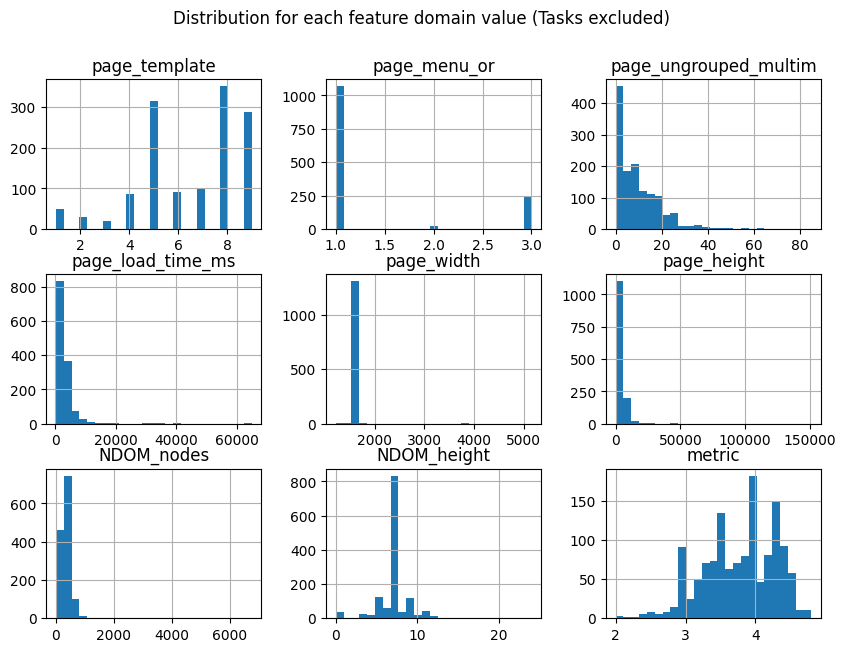

In [8]:
import matplotlib.pyplot as plt

hist_columns = ds3_features_part1+ds3_features_part2 # + ds3_features_part3
hist_columns.append(ds3_target)

# >>>
df1.hist(bins=25, column=hist_columns, figsize=(10,7))
plt.suptitle("Distribution for each feature domain value (Tasks excluded)")

E' anche possibile visualizzare la correlazione che c'è tra ciascuna feature, e più in particolare, è di nostro interesse la misura con cui ciascuna input feature incide sulla feature target `metric`.

<Axes: >

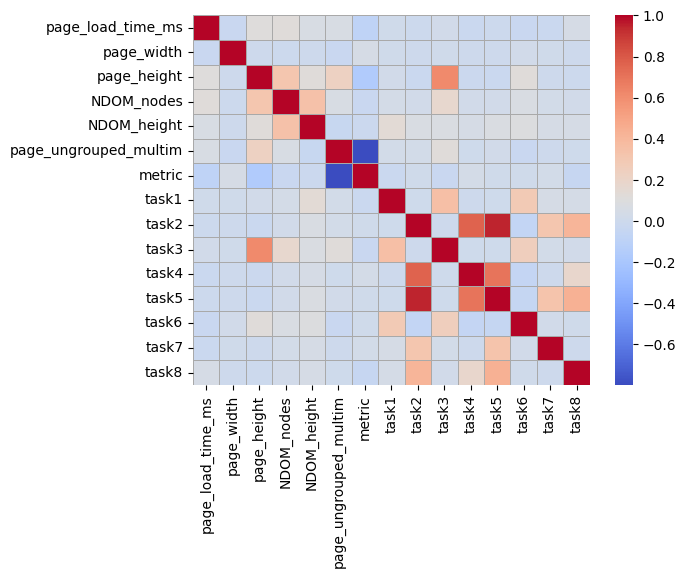

In [9]:
import seaborn as sns

df1_correlation = df1.drop(ds3_features_pk+features_discrete, axis=1).corr(method="pearson")
sns.heatmap(df1_correlation, linewidths=0.5, linecolor='darkgray', cmap="coolwarm")

### Creazione Training-Set (TS) e Test-Set (TE)

Poichè il DS ha un numero basso di righe, è stato utilizzato il rapporto di splitting 70% (per il TS) e 30% (TE).

In [10]:
from sklearn.model_selection import train_test_split

ds3_features_excluded = ds3_features_pk + ds3_features_part1
ds3_features_excluded.append(ds3_target)

# X (tabella con colonne input feature) e y (tabella target)
X = df1.drop(ds3_features_excluded, axis=1)
y = df1[ds3_target]

X_TS, X_TE, gt_y_TS, gt_y_TE = train_test_split(X, y, test_size=0.3, random_state=42)

# creazione dizionario performances
performances = dict()

## Modelli di regressione

In questa sezione cerchiamo il/i modello/i che si avvicina di più al Ground Truth, mettendoli tutti su una stessa scala di giudizio, ovvero le metriche di misurazione degli errori. In questo progetto, assumiamo che le metriche di un qualsiasi modello di apprendimento devono essere calcolate facendo in modo che il modello possa sfruttare tutti i dati dell'intero DS. Per questo motivo, possiamo dire che la tecnica di [k-fold Cross Validation](https://scikit-learn.org/stable/modules/cross_validation.html) verrà impiegata in due casistiche:
- quando vogliamo ottenere delle metriche di errore affidabili per un determinato modello, a prescindere dal numero di iperparametri da configurare.
- quando vogliamo trovare una configurazione ottimale di iperparametri per un determinato modello.

### Regressore Lineare (0 iperp. considerati)

Costruiamo un regressore lineare, tenendo conto che non ci sono iperparametri da ottimizzare.

In [11]:
from sklearn.linear_model import LinearRegression

# modello
model_name = "Regressore Lineare"
reglin = LinearRegression()
reglin.fit(X_TS, gt_y_TS)

# predizione
reglin_y_TS = reglin.predict(X_TS)
# i valori predetti < 1 (o > 5) vengono fixati a 1 e 5
#reglin_y_TS = np.clip(reglin_y_TS, METRIC_MIN_VAL, METRIC_MAX_VAL)

reglin_y_TE = reglin.predict(X_TE)
#reglin_y_TE = np.clip(reglin_y_TE, METRIC_MIN_VAL, METRIC_MAX_VAL)

#### Cambio categoria e penalità applicata all'errore

Dopo aver costruito il modello, diamo un'occhiata ai valori effettivi della feature target (nel TS) e le relative previsioni.

In [12]:
gt_y_TS # fisso

1297    3.5
620     3.6
1193    4.4
139     4.5
1165    2.9
       ... 
1095    4.4
1130    3.0
1294    3.5
860     3.5
1126    3.6
Name: metric, Length: 930, dtype: float64

In [13]:
from pandas import Series

# >>>
Series(reglin_y_TS) # fisso

0      3.798217
1      3.782822
2      3.829767
3      3.861078
4      3.826994
         ...   
925    3.822869
926    3.735890
927    3.833909
928    3.802649
929    3.817001
Length: 930, dtype: float64

Calcoliamo manualmente l'errore che otteniamo. Questa operazione sarà poi ottimizzata, ma per il momento lo facciamo per avere una panoramica sulle percentuali di errore fatte dal modello.

In [14]:
err = np.subtract(reglin_y_TS, gt_y_TS) # fisso

# >>>
err

1297    0.298217
620     0.182822
1193   -0.570233
139    -0.638922
1165    0.926994
          ...   
1095   -0.577131
1130    0.735890
1294    0.333909
860     0.302649
1126    0.217001
Name: metric, Length: 930, dtype: float64

Il calcolo "manuale" dell'errore che il modello fa sul target **di questo specifico TS** è stato fatto per poter vedere quante volte il modello fa una previsione che si discosta dal valore attuale di una certa percentuale. L'istogramma generato di seguito ha solo funzione informativa e solo in questa evenienza si è calcolato l'errore con segno. In seguito, quando si andrà a calcolare le metriche dei modelli, si useranno le metriche convenzionali di misurazione dell'errore.

Sull'asse X dell'istogramma ci sono le possibili percentuali di errore (da -100% a 100%) ad indicare il fatto che il modello può fare una previsione con un errore percentuale negativo (il modello predice una valutazione minore della valutazione reale), uguale a 0, o positivo.
Ad es. un errore -100% si verifica quando il valore attuale di `metric` è 5 e il modello predice 1. In corrispondenza di una percentuale, sull'asse Y il grafico dice per quanti esempi del TS il modello fa una predizione con questo errore percentuale.

<Axes: >

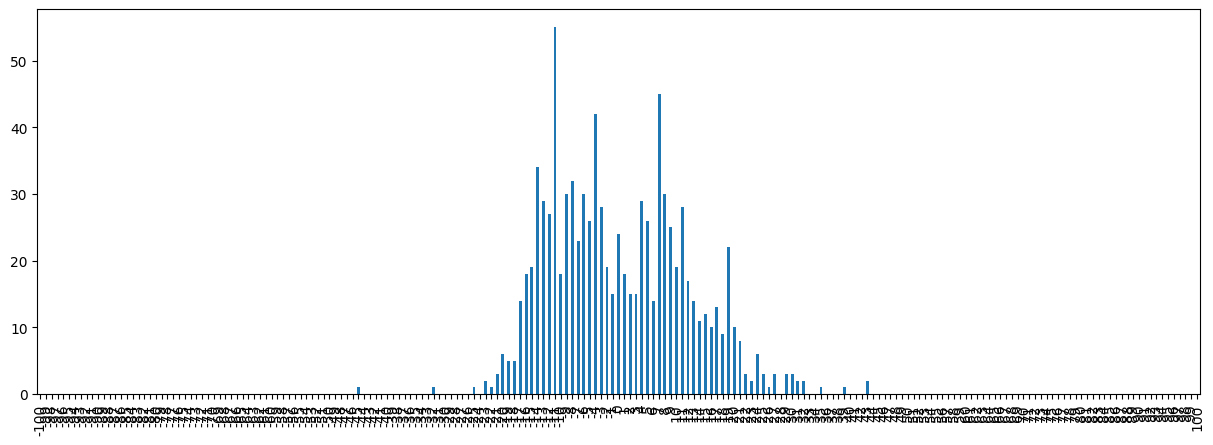

In [17]:
# siccome abbiamo applicato la funzione clip sull'array delle previsioni,
# conosciamo il valore di un ipotetico errore massimo
max_error = METRIC_MAX_VAL - METRIC_MIN_VAL

def calc_err_percentage(x):
    perc = float((x*100)/max_error)
    return int(perc)

# creo una nuova serie che associa ad ogni elemento la sua percentuale di errore
err_percentage = err.apply(calc_err_percentage)

err_percentage_count = err_percentage.value_counts()
err_percentage_count = err_percentage_count.reindex(range(-100, 101), fill_value=0)
err_percentage_count = err_percentage_count.sort_index()

# >>>
err_percentage_count.plot(kind='bar', figsize=(15,5))

Il modello (sugli esempi di questo specifico TS) non fa errori molto gravi (vale a dire errori minori del -50% o maggiori del 40%) ma possiamo fare una osservazione.

Consideriamo una pagina web per il quale la valutazione è 3.2. Se il modello fa un errore (anche piccolo) di -0.4 punti, si verifica un vero e proprio cambio categoria: il sito teoricamente è *Accettabile*, ma il modello lo classifica come *Confuso*. Situazione diversa si ha se il modello fa un errore (ancora piccolo) di 0.4 punti, e quindi il modello predice il valore 3.6, senza che si verifica un cambio categoria.

**Sarebbe corretto in questa casistica parlare di errori equivalenti?** Si ipotizza di no, per cui si introduce un errore aggiuntivo che il modello compie qualora vada a cambiare una categoria. In altre parole, stiamo "forzando" i modelli che addestreremo a compiere un errore quanto più basso possibile soprattutto per le pagine la cui valutazione è a un'estremità (inferiore o superiore) della categoria corrente.

La penalità che calcoliamo viene definita con la funzione `calc_err_penalty` che si comporta nel seguente modo:
- se non c'è un cambio categoria, l'errore del modello non subisce una ulteriore penalità.
- se c'è un cambio categoria allora viene applicata la penalità, che dipende dal numero di categorie tra quella attuale e quella prevista. Eventualmente, possiamo anche prevedere delle penalità più severe se il modello predice una categoria peggiore rispetto a quella attuale (`page_category_shift` < 0)

Il comportamento di questa funzione è visibile da questo [grafico](https://www.desmos.com/calculator/bizzgpum9h?lang=it). Avremmo potuto implementare questa funzione con un semplice if-else, però il grafico (poichè non è simmetrico all'asse Y) evidenzia il fatto delle penalità più severe quando `page_category_shift` < 0. Infine, dobbiamo precisare che le penalità relative a quando `page_category_shift` < 0 devono avere segno negativo, altrimenti andrebbero contro il nostro intento. Per comodità, nel grafico, tutte le penalità hanno segno positivo.

In [18]:
def calc_err_penalty(y_gt, y_pred):
    """ Calcola la penalità da sommare all'errore qualora c'è un cambio categoria.

    Args:
        - y_gt: Target attuale.
        - y_pred: Target previsto dal modello (include un errore).
    """

    pred_category = int(y_pred) # positivo
    gt_category = int(y_gt) # positivo

    page_category_shift = pred_category - gt_category
    #page_category_shift può essere < 0 (modello predice categoria più bassa)
    # = 0 (stessa categoria)
    # > 0 (modello predice categoria più alta)

    if page_category_shift == 0:
        return y_pred

    elif (page_category_shift < 0 and gt_category <= METRIC_MIN_VAL) or \
        (page_category_shift > 0 and gt_category >= METRIC_MAX_VAL - 1):
        # c'è un cambio categoria ma non lo consideriamo tale
        return y_pred

    else:
        # calcolo penalty
        a = 0.01
        b = -0.004
        c = 0.165
        penalty = (((a)*(page_category_shift**2))+
                ((b)*page_category_shift)+
                (c)
        )
        if page_category_shift < 0:
            penalty = penalty*(-1)
        # ---

        err_category = int(y_pred + penalty) # positivo

        if pred_category == err_category:
            return y_pred + penalty

        # evito che la penalità sia eccessiva
        elif page_category_shift < 0:
            return y_pred + (pred_category - y_pred) #y_pred + (<0)
        else:
            #return y_pred + (penalty - (y_pred + penalty - err_category + 0.1))
            return y_pred + (err_category - y_pred - 0.1)

# vettorizza funzione
vcalc_err_penalty = np.vectorize(calc_err_penalty, otypes=[float])

In [19]:
reglin_y_TS = vcalc_err_penalty(gt_y_TS, reglin_y_TS)
reglin_y_TS = np.clip(reglin_y_TS, METRIC_MIN_VAL, METRIC_MAX_VAL)

# >>>
Series(reglin_y_TS)

0      3.798217
1      3.782822
2      3.650767
3      3.682078
4      3.997994
         ...   
925    3.643869
926    3.735890
927    3.833909
928    3.802649
929    3.817001
Length: 930, dtype: float64

Aggiorniamo le predizioni che il Regressore Lineare fa sul TS (già fatto) e TE.

In [ ]:
#reglin_y_TS = vcalc_err_penalty(gt_y_TS, reglin_y_TS)
#reglin_y_TS = np.clip(reglin_y_TS, METRIC_MIN_VAL, METRIC_MAX_VAL)

reglin_y_TE = vcalc_err_penalty(gt_y_TE, reglin_y_TE)
reglin_y_TE = np.clip(reglin_y_TE, METRIC_MIN_VAL, METRIC_MAX_VAL)

Calcoliamo le metriche delle performance di questo modello sui dati del TE.

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# performance
reglin_perf = dict()
reglin_perf["MAE (TS)"] = mean_absolute_error(gt_y_TS, reglin_y_TS)
reglin_perf["MSE (TS)"] = mean_squared_error(gt_y_TS, reglin_y_TS)
reglin_perf["RMSE (TS)"] = mean_squared_error(gt_y_TS, reglin_y_TS, squared=False)
reglin_perf["R^2 (TS)"] = r2_score(gt_y_TS, reglin_y_TS)

reglin_perf["MAE (TE)"] = mean_absolute_error(gt_y_TE, reglin_y_TE)
reglin_perf["MSE (TE)"] = mean_squared_error(gt_y_TE, reglin_y_TE)
reglin_perf["RMSE (TE)"] = mean_squared_error(gt_y_TE, reglin_y_TE, squared=False)
reglin_perf["R^2 (TE)"] = r2_score(gt_y_TE, reglin_y_TE)

reglin_perf_table = pd.DataFrame(reglin_perf, index=[model_name])

# aggiungi alla raccolta delle performances
performances[model_name] = reglin_perf

# >>>
reglin_perf_table

,MAE (TS),MSE (TS),RMSE (TS),R^2 (TS),MAE (TE),MSE (TE),RMSE (TE),R^2 (TE)
Regressore Lineare,0.508605,0.344285,0.586758,-0.340711,0.513798,0.360866,0.600722,-0.370697


### Regressore SVM (2 iperp. considerati)



In [ ]:
from sklearn.svm import SVR
from itertools import product

regSVR_params = {
    'kernel': ['linear', 'rbf'],
    'epsilon': [0.1, 0.2, 0.3]
}

# prodotto cartesiano di tutti i domini degli iperparametri
regSVR_param_combos = list(product(*list(regSVR_params.values())))

# creazione del modello con una specifica combinazione di iperparametri
for combo in regSVR_param_combos:
    kernel = combo[0]
    epsilon = combo[1]

    # modello
    regSVR = SVR(kernel=kernel, epsilon=epsilon)
    model_name = f"SVR {combo}"

    # predizione
    regSVR_y_TS = regSVR.predict(X_TS)
    regSVR_y_TS = vcalc_err_penalty(gt_y_TS, regSVR_y_TS)
    regSVR_y_TS = np.clip(regSVR_y_TS, METRIC_MIN_VAL, METRIC_MAX_VAL)

    regSVR_y_TE = regSVR.predict(X_TE)
    regSVR_y_TE = vcalc_err_penalty(gt_y_TE, regSVR_y_TE)
    regSVR_y_TE = np.clip(regSVR_y_TE, METRIC_MIN_VAL, METRIC_MAX_VAL)

    # performance
    reglin_perf = dict()
    reglin_perf["MAE (TS)"] = mean_absolute_error(gt_y_TS, reglin_y_TS)
    reglin_perf["MSE (TS)"] = mean_squared_error(gt_y_TS, reglin_y_TS)
    reglin_perf["RMSE (TS)"] = mean_squared_error(gt_y_TS, reglin_y_TS, squared=False)
    reglin_perf["R^2 (TS)"] = r2_score(gt_y_TS, reglin_y_TS)

    reglin_perf["MAE (TE)"] = mean_absolute_error(gt_y_TE, reglin_y_TE)
    reglin_perf["MSE (TE)"] = mean_squared_error(gt_y_TE, reglin_y_TE)
    reglin_perf["RMSE (TE)"] = mean_squared_error(gt_y_TE, reglin_y_TE, squared=False)
    reglin_perf["R^2 (TE)"] = r2_score(gt_y_TE, reglin_y_TE)

    reglin_perf_table = pd.DataFrame(reglin_perf, index=[model_name])


reglin_y_TE = reglin.predict(X_TE)
reglin_y_TE = np.clip(reglin_y_TE, METRIC_MIN_VAL, METRIC_MAX_VAL)

reglin_y_TE = vcalc_err_penalty(gt_y_TE, reglin_y_TE)
reglin_y_TE = np.clip(reglin_y_TE, METRIC_MIN_VAL, METRIC_MAX_VAL)


# modello

dom_kernel = ['linear', 'rbf']
dom_epsilon = [0.1, 0.2, 0.3]

'''
for ip_kernel in dom_kernel:





regrSVR_cv = GridSearchCV(regrSVR, regrSVR_params)
regrSVR_cv.fit(X_TS, gt_y_TS)

sorted(regrSVR_cv.cv_results_.keys())
regSVR = SVR()
reglin.fit(X_TS, gt_y_TS)

# predizione
reglin_y_TS = reglin.predict(X_TS)
# i valori predetti < 1 (o > 5) vengono fixati a 1 e 5
reglin_y_TS = np.clip(reglin_y_TS, METRIC_MIN_VAL, METRIC_MAX_VAL)

reglin_y_TE = reglin.predict(X_TE)
reglin_y_TE = np.clip(reglin_y_TE, METRIC_MIN_VAL, METRIC_MAX_VAL)
'''